In [1]:
using Statistics
using NCDatasets
#using Knet
using Flux
using Flux: throttle
using PyPlot
using MLDataUtils

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1192
┌ Info: Precompiling MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1192
┌ Warning: Replacing docs for `MLLabelUtils.labelmap :: Union{}` in module `MLLabelUtils`
└ @ Base.Docs docs/Docs.jl:223


loaded


In [2]:
fname = expanduser("~/tmp/LS2v/Calvi-2015-u3hadv-vega/Calvi-2015-u3hadv/ocean_his.nc")
ds = Dataset(fname)


Dataset: /home/abarth/tmp/LS2v/Calvi-2015-u3hadv-vega/Calvi-2015-u3hadv/ocean_his.nc
Group: /

Dimensions
   xi_rho = 276
   xi_u = 275
   xi_v = 276
   xi_psi = 275
   eta_rho = 150
   eta_u = 150
   eta_v = 149
   eta_psi = 149
   N = 32
   s_rho = 32
   s_w = 33
   tracer = 2
   boundary = 4
   ocean_time = 61

Variables
  ntimes  
    Attributes:
     long_name            = number of long time-steps

  ndtfast  
    Attributes:
     long_name            = number of short time-steps

  dt  
    Attributes:
     long_name            = size of long time-steps
     units                = second

  dtfast  
    Attributes:
     long_name            = size of short time-steps
     units                = second

  dstart  
    Attributes:
     long_name            = time stamp assigned to model initilization
     units                = days since 1858-11-17 00:00:00

  nHIS  
    Attributes:
     long_name            = number of time-steps between history records

  ndefHIS  
    Attribut

In [3]:
n = 1:61
lon = nomissing(ds["lon_rho"][:],NaN)
lat = nomissing(ds["lat_rho"][:],NaN)
temp = nomissing(ds["temp"][:,:,end,n],NaN)
salt = nomissing(ds["salt"][:,:,end,n],NaN)
zeta = nomissing(ds["zeta"][:,:,n],NaN)

ocean_time = nomissing(ds["ocean_time"][n])
mask = nomissing(ds["mask_rho"][:,:]) .== 1;

In [4]:
Ntimes = length(ocean_time);
lon3 = repeat(lon,inner=(1,1,Ntimes))
lat3 = repeat(lat,inner=(1,1,Ntimes));
time3 = repeat(reshape(1:Ntimes,(1,1,Ntimes)),inner=(size(lon,1),size(lon,2),1))
mask3 = repeat(mask,inner=(1,1,Ntimes));

@show size(time3),size(lon3)

(size(time3), size(lon3)) = ((276, 150, 61), (276, 150, 61))


((276, 150, 61), (276, 150, 61))

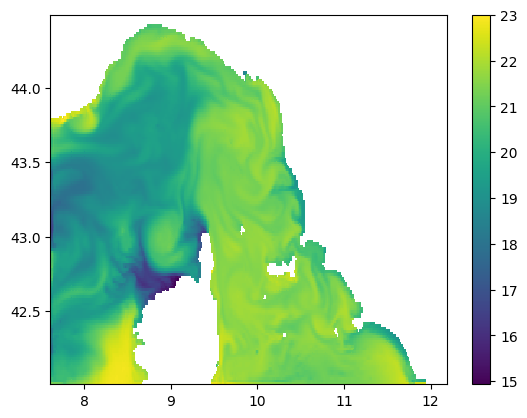

In [5]:
pcolor(lon,lat,temp[:,:,end]); colorbar();

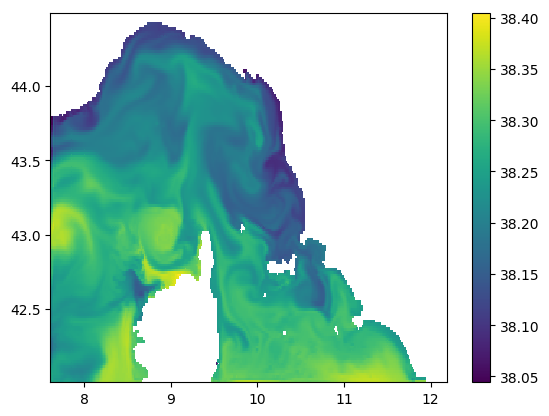

In [6]:
pcolor(lon,lat,salt[:,:,end]); colorbar();

In [7]:
size(mask)

(276, 150)

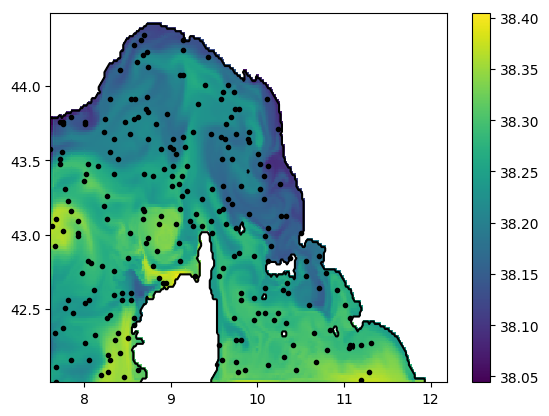

PyObject <matplotlib.contour.QuadContourSet object at 0x7f5e2ed8aac8>

In [8]:
sel = (rand(Float64,size(temp)) .< 0.01) .& mask;
sel_last = sel .& (time3 .== maximum(time3))
pcolor(lon,lat,salt[:,:,end]); colorbar();
plot(lon3[sel_last],lat3[sel_last],"k.")
contour(lon,lat,Int.(mask),[0.5],colors="k")

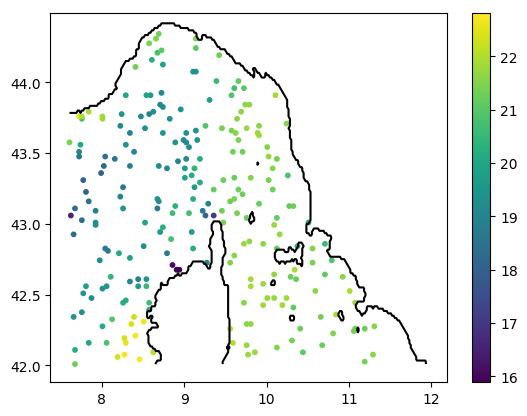

In [9]:
scatter(lon3[sel_last],lat3[sel_last],10,temp[sel_last]);colorbar();
contour(lon,lat,mask,[0.5],colors="k");


In [10]:
X = vcat(lon3[sel]',lat3[sel]',time3[sel]',temp[sel]',zeta[sel]')
Y = salt[sel]'

@show size(X)
@show size(Y)

meanX = mean(X,dims=2)
meanY = mean(Y,dims=2)

X = X .- meanX
Y = Y .- meanY


size(X) = (5, 13441)
size(Y) = (1, 13441)


1×13441 Array{Float32,2}:
 0.092659  0.175117  0.0939064  …  -0.0547867  -0.0596924  -0.0487175

In [11]:
m = Chain(Dense(size(X,1),4,σ),
    Dense(4,4,σ),
    Dense(4,3,σ),
    Dense(3,1),
)
loss(x, y) = Flux.mse(m(x), y)
#dataset = repeated((X, Y), 200)
dataset = batchview((X,Y),size=100);
evalcb = () -> @show(sqrt(loss(X, Y)))

┌ Warning: The specified values for size and/or count will result in 41 unused data points
└ @ MLDataPattern /home/abarth/.julia/packages/MLDataPattern/mX21p/src/dataview.jl:204


#7 (generic function with 1 method)

In [12]:
@time for i = 1:100
Flux.train!(loss, dataset, ADAM(Flux.params(m)), cb = throttle(evalcb, 1000))
end

sqrt(loss(X, Y)) = 0.09898566091770834 (tracked)
sqrt(loss(X, Y)) = 0.09720705102280501 (tracked)
sqrt(loss(X, Y)) = 0.09276486688259789 (tracked)
sqrt(loss(X, Y)) = 0.08747154193953227 (tracked)
sqrt(loss(X, Y)) = 0.08500751843169159 (tracked)
sqrt(loss(X, Y)) = 0.08303262668171188 (tracked)
sqrt(loss(X, Y)) = 0.08086813949490482 (tracked)
sqrt(loss(X, Y)) = 0.07880380921333377 (tracked)
sqrt(loss(X, Y)) = 0.07695569457701949 (tracked)
sqrt(loss(X, Y)) = 0.07514249419083742 (tracked)
sqrt(loss(X, Y)) = 0.07348202053676897 (tracked)
sqrt(loss(X, Y)) = 0.07203046916159765 (tracked)
sqrt(loss(X, Y)) = 0.07074504551989802 (tracked)
sqrt(loss(X, Y)) = 0.06882561246663851 (tracked)
sqrt(loss(X, Y)) = 0.06814771054524439 (tracked)
sqrt(loss(X, Y)) = 0.06761754544524679 (tracked)
sqrt(loss(X, Y)) = 0.067262321716863 (tracked)
sqrt(loss(X, Y)) = 0.06696093971417467 (tracked)
sqrt(loss(X, Y)) = 0.06676434439570493 (tracked)
sqrt(loss(X, Y)) = 0.06657205013956453 (tracked)
sqrt(loss(X, Y)) = 0.0

In [13]:
@show extrema(Y)

extrema(Y) = (-0.20864868f0, 0.2580452f0)


(-0.20864868f0, 0.2580452f0)

In [14]:
Ypred = Tracker.data(m(X))
@show extrema(Ypred)

extrema(Ypred) = (-0.18478433162959818, 0.1977457563055533)


(-0.18478433162959818, 0.1977457563055533)

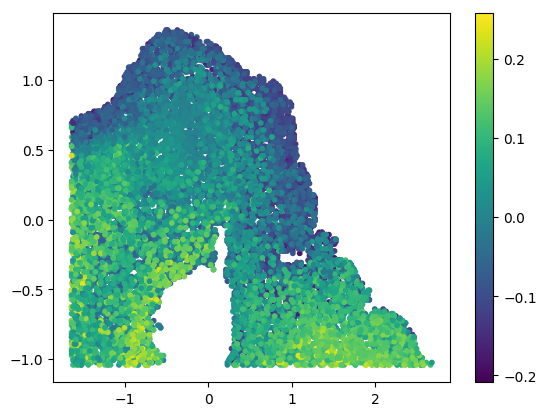

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5e344cf198>

In [15]:
scatter(copy(X[1,:]),copy(X[2,:]),10,Y[1,:]); colorbar()

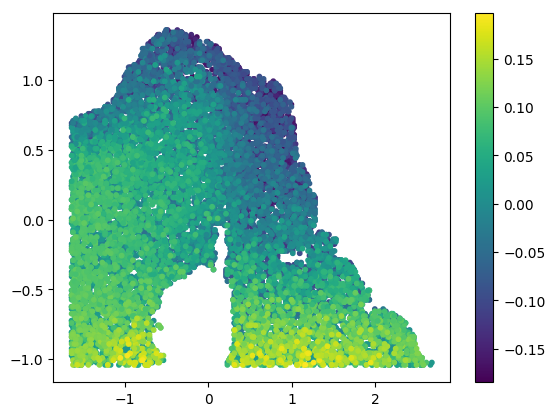

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5e3bbcbfd0>

In [16]:
scatter(copy(X[1,:]),copy(X[2,:]),10,Ypred[1,:]); colorbar()

In [17]:
Xall = vcat(lon3[:]',lat3[:]',time3[:]',temp[:]',zeta[:]') .- meanX;
Yall = Tracker.data(m(Xall)) .+ meanY
salt_pred = reshape(Yall,size(temp));

In [18]:
cl = extrema(salt[isfinite.(salt)])

(37.799812f0, 38.442337f0)

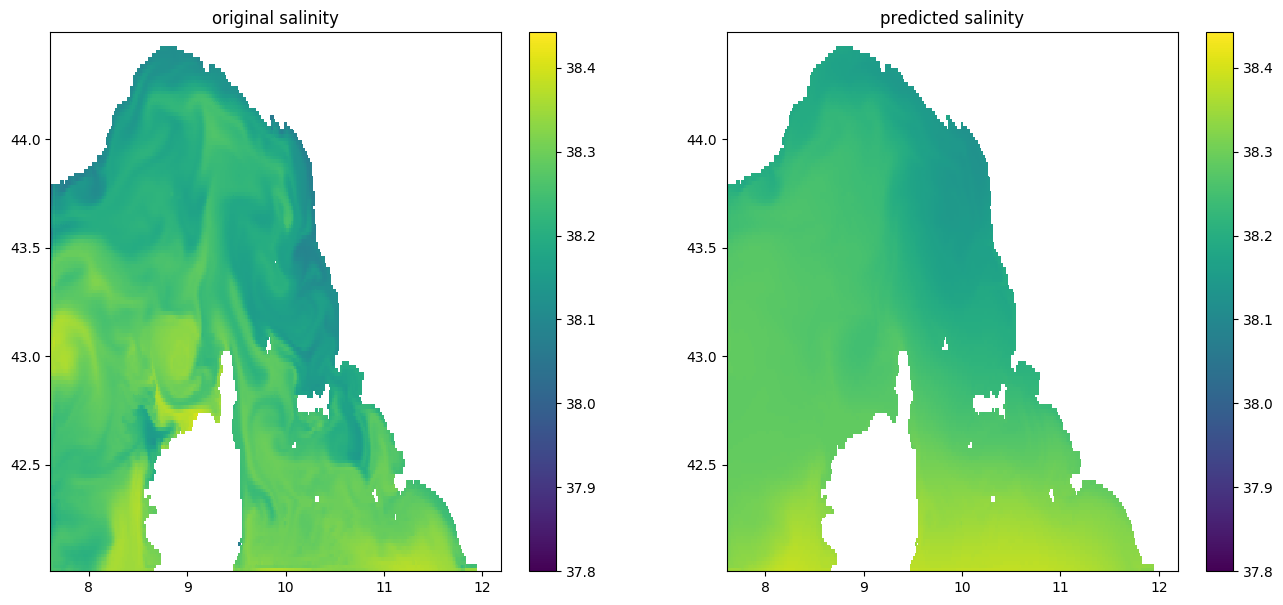

In [19]:
figure(figsize=(16,7))
subplot(1,2,1)
pcolor(lon,lat,salt[:,:,end]); clim(cl); colorbar()
title("original salinity")

subplot(1,2,2)
pcolor(lon,lat,salt_pred[:,:,end]); clim(cl); colorbar()
title("predicted salinity");
